In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cuda


In [2]:
def data_loader(data, batch_size, random_seed=123, valid_size=0.1, shuffle=True,test=False):
    normalise = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),normalise])
    transform_train = transforms.Compose(
        [
        transforms.RandomRotation(5),
         transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         normalise])
    if test:
        dataset = datasets.Flowers102(root=data, split="test", download=True, transform=transform)
        data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
        print(f"Number of test examples: {len(dataset)}")
        return data_loader
    train_dataset = datasets.Flowers102(root=data, split="train", download=True, transform=transform_train)
    validation_dataset = datasets.Flowers102(root=data, split="val", download=True, transform=transform)
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    # train_idx, valid_idx = indices[split:], indices[:split]
    # train_sampler = torch.utils.data.sampler.SubsetRandomSampler(1020)
    # valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(1020)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True)
    print(f"Number of training examples: {len(train_dataset)}")
    return (train_loader, valid_loader)

train_loader, valid_loader = data_loader(data='flowers', batch_size=4, shuffle=True, test=False)
test_loader = data_loader(data='flowers', batch_size=4, shuffle=True, test=True)
# normalise = transforms.Normalize(mean=[0.4914,0.4822,0.4465],std=[0.2023,0.1994,0.2010])
# transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),normalise])
# transform_train = transforms.Compose(
#     [transforms.Resize((256,256)),
#      transforms.RandomHorizontalFlip(),
#      transforms.RandomVerticalFlip(p=0.5),
#      transforms.CenterCrop(224),
#      transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.4, hue=0.1),
#      transforms.RandomRotation(10),
# #      transforms.ToTensor(),
# #      normalise])
# train_dataset = datasets.Flowers102(root='./data', split="train", download=True, transform=transform_train)
# validation_dataset = datasets.Flowers102(root="./data/", split="val", download=True, transform=transform)
# test = datasets.Flowers102(root="./data", split="test", download=True, transform=transform)
# train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
# valid_loader = DataLoader(dataset=validation_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(dataset=test, batch_size=32, shuffle=False)


Number of training examples: 1020
Number of test examples: 6149


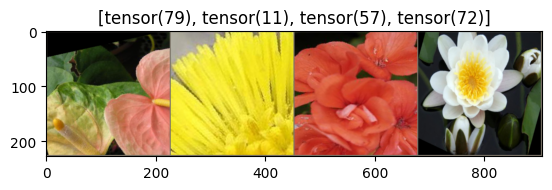

In [3]:
import torchvision
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x for x in classes])
     


In [4]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Block, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [5]:
class Rn(nn.Module):
    def __init__(self, block, layers, num_classes=102):
        super(Rn, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels=self.in_planes, out_channels=planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x
    

In [6]:
num_classes = 102
num_epochs = 300
learning_rate = 0.0001
weight_decay = 5e-4
print_every = 5
model = Rn(Block, [2,2,2,2], num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
print(train_loader)
total_step = len(train_loader)

In [7]:
def count_parameters(model)->int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

11230758


In [8]:
import requests
def post_discord(epoch,train_loss, val_accuracy):
    data = {
        "username": "Flower Classifier - colab"
    }
    data["embeds"] = [
        {
            "title": "Epoch {} Results".format(epoch),
            "color": 0x00ff00,
            "fields": [
                {
                    "name": "Training Loss",
                    "value": f"{train_loss}",
                    "inline": False
                },
                {
                    "name": "Validation Accuracy",
                    "value": f"{val_accuracy}",
                    "inline": False
                },
            ]
        }
    ]
    r = requests.post("https://discord.com/api/webhooks/1052587856343867392/SnR2U4HIdeF6ShECr0k1Mit6yrl3HgjtCMk_LykGD8eQ1qsZViY8HLeYsoBUXOHYfbgP", json=data)
    print(r.status_code)


In [15]:
import gc
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        gc.collect()
    
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    
    if epoch % print_every == 0:
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            correct = 0
            total = 0
            correctT = 0
            totalT = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted==labels).sum().item()
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                totalT += labels.size(0)
                correctT += (predicted==labels).sum().item()

            print('Training Accuracy accross {} images: {} %'.format(totalT, 100 * correctT / totalT))
            print('Validation Accuracy accross {} images: {} %'.format(total, 100 * correct / total))
            post_discord(epoch+1, '{:.4f}'.format(loss.item()), 100 * correct / total)
    if epoch % 100 == 0:
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
        print('Test Accuracy accross {} images: {} %'.format(totalT, 100 * correct / total))
        torch.save(model.state_dict(), 'model-{}.pth'.format(100 * correct / total))


Epoch [1/1000], Loss: 0.4536
Training Accuracy accross 1020 images: 91.17647058823529 %
Validation Accuracy accross 1020 images: 58.92156862745098 %
204
Test Accuracy accross 1020 images: 91.17647058823529 %
Epoch [2/1000], Loss: 1.1626
Epoch [3/1000], Loss: 0.0869
Epoch [4/1000], Loss: 0.8772
Epoch [5/1000], Loss: 1.2030
Epoch [6/1000], Loss: 0.2185
Training Accuracy accross 1020 images: 91.96078431372548 %
Validation Accuracy accross 1020 images: 58.03921568627451 %
204
Epoch [7/1000], Loss: 2.1336
Epoch [8/1000], Loss: 0.1127
Epoch [9/1000], Loss: 1.1453
Epoch [10/1000], Loss: 0.1340
Epoch [11/1000], Loss: 0.0575
Training Accuracy accross 1020 images: 90.19607843137256 %
Validation Accuracy accross 1020 images: 58.92156862745098 %
204
Epoch [12/1000], Loss: 2.0523
Epoch [13/1000], Loss: 0.9503
Epoch [14/1000], Loss: 0.1721
Epoch [15/1000], Loss: 0.1644
Epoch [16/1000], Loss: 1.2009
Training Accuracy accross 1020 images: 94.90196078431373 %
Validation Accuracy accross 1020 images: 58

In [14]:
torch.save(model.state_dict(), 'model_5.pth')

In [11]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))   


Accuracy of the network on the 6149 test images: 50.18702228004553 %


In [12]:
def count_parameters(model)->int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

11230758


In [13]:
print(model)

Rn(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): Block(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): Block(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, mom